<a href="https://colab.research.google.com/github/Kluthra15/twitter_marketing_ML/blob/main/Twitter_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install twitter
!pip install umap
!pip install hdbscan
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3543 sha256=627e4f463270edf18ef019bae412ccabf154325ed461cc81eb0df78a9852f9af
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039155 sha256=9f2617cb398217a8b15a9f170ae4fa31a03d8be3e575fb35e1897e59601dfa56
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87

In [ ]:
import tweepy
import configparser
import requests     # For saving access tokens and for file management when creating and adding to the dataset
import os           # For dealing with json responses we receive from the API
import json         # For displaying the data after
import pandas as pd # For saving the response data in CSV format
import numpy as np
import csv          # For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata  #To add wait time between requests
import time
import sqlite3
import re
# import twitter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance,PartOfSpeech
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from nltk.corpus import stopwords
from sklearn.model_selection import RandomizedSearchCV
# from flair.embeddings import TransformerDocumentEmbeddings
# from twitter import *
from functools import partial
from collections import Counter
import nltk
import string
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set up SQLite database
conn = sqlite3.connect('/content/drive/MyDrive/Colab_Notebooks/Data/twitter_data.db')
c = conn.cursor()

In [ ]:
# Getting all tables from sqlite_master
sql_query = """SELECT name FROM sqlite_master
WHERE type='table';"""

# executing our sql query
c.execute(sql_query)
print("List of tables\n")

# printing all tables list
print(c.fetchall())

List of tables

[('tweets',), ('users',)]


In [ ]:
# Define a function to get the number of rows in a table
def get_row_count(table_name):
    sql_query = f"SELECT COUNT(*) FROM {table_name};"
    c.execute(sql_query)
    count = c.fetchone()[0]
    return count

# List of table names
table_names = ['tweets', 'users']

# Iterate through the tables and get row counts
for table_name in table_names:
    row_count = get_row_count(table_name)
    print(f"Number of rows in '{table_name}' table: {row_count}")

Number of rows in 'tweets' table: 36370
Number of rows in 'users' table: 14026


## Set up SQLite database

The following code sets up an SQLite database and creates two tables: `tweets` and `users`.


### Retrieve Data from SQLite Database

The following code retrieves data from the SQLite database and creates Pandas DataFrames: `tweets_df` and `users_df`.


In [ ]:
# Retrieve the data from the SQLite database
query = "SELECT * FROM tweets"
tweets_df = pd.read_sql_query(query, conn, parse_dates=['created_at'])
print(tweets_df.dtypes)


# Retrieve the data from the SQLite database
query = "SELECT * FROM users"
users_df = pd.read_sql_query(query, conn, parse_dates=['author_created'])
print(users_df.dtypes)

tweet_id                  int64
author_id                 int64
created_at       datetime64[ns]
text                     object
tweet_metrics            object
entities                 object
context                  object
place_id                 object
dtype: object
author_id                        int64
username                        object
verified                        object
bio                             object
author_created     datetime64[ns, UTC]
author_location                 object
followers_count                  int64
following_count                  int64
tweet_count                      int64
entities                        object
dtype: object


In [ ]:
# tweets_df.info()
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14026 entries, 0 to 14025
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   author_id        14026 non-null  int64              
 1   username         14026 non-null  object             
 2   verified         14026 non-null  object             
 3   bio              14026 non-null  object             
 4   author_created   14026 non-null  datetime64[ns, UTC]
 5   author_location  14026 non-null  object             
 6   followers_count  14026 non-null  int64              
 7   following_count  14026 non-null  int64              
 8   tweet_count      14026 non-null  int64              
 9   entities         14026 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(4), object(5)
memory usage: 1.1+ MB


## Data Pre-Processing

The following code will remove emoticons, hyperlinks, whitepsaces such as new lines and indentations.
It will also tokenize text into words, remove slang words, and visualize the text pre-processed data to show patterns

In [ ]:
def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

In [ ]:
def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def countEmoticons(text):
    """ Input: a text, Output: how many emoticons """
    return len(re.findall(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', text))


In [ ]:
nltk.download('stopwords')

""" Tokenizes a text to its words, removes and replaces some of them """
finalTokens = [] # all tokens
stoplist = stopwords.words('english')
my_stopwords = "multiexclamation multiquestion multistop url atuser st rd nd th am pm" # my extra stopwords
stoplist = stoplist + my_stopwords.split()
allowedWordTypes = ["J","R","V","N"] #  J is Adject, R is Adverb, V is Verb, N is Noun. These are used for POS Tagging

# Create a DataFrame to store the preprocessed text and tweet ID
preprocessed_data = pd.DataFrame(columns=['tweet_id', 'text'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def tokenize(text, wordCountBefore, tweet_id):
    totalAdjectives = 0
    totalAdverbs = 0
    totalVerbs = 0
    onlyOneSentenceTokens = []  # tokens of one sentence each time

    tokens = nltk.word_tokenize(text)

    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)  # Technique 7: remove punctuation

    tokens = nltk.word_tokenize(text)

    tagged = nltk.pos_tag(tokens)  # Technique 13: part of speech tagging
    for w in tagged:
        if w[1][0] in allowedWordTypes and w[0] not in stoplist:
            onlyOneSentenceTokens.append(w[0])
            finalTokens.append(w[0])

    onlyOneSentence = " ".join(onlyOneSentenceTokens)

    # Store the preprocessed text and tweet ID in the DataFrame
    preprocessed_data.loc[len(preprocessed_data)] = [tweet_id, onlyOneSentence]

    return finalTokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


              tweet_id  \
0  1658150278699565056   
1  1658150503149187076   
2  1658150654756397056   
3  1658150765599371276   
4  1658151031182700552   

                                                                                                                                                                                text  
0                                             dont anything share countries time meantime use Atlas easily incorporate US company set US bank account activate payments Stripe Learn  
1                 HPE NVIDIA FlywheelSoftwa1 developed Biomedical Research Data Platform AI Scale extends realtime clinical insights edge cloud Learn blog HPEGreenLake HPEAlliances  
2  FortiXDR cloud native crossproduct detection response solution adds fullyautomated incident identification investigation remediation Fortinet SecurityFabric Watch learn FortiXDR  
3                                                           DYK NASAs Perseverance Mars rover recently discover

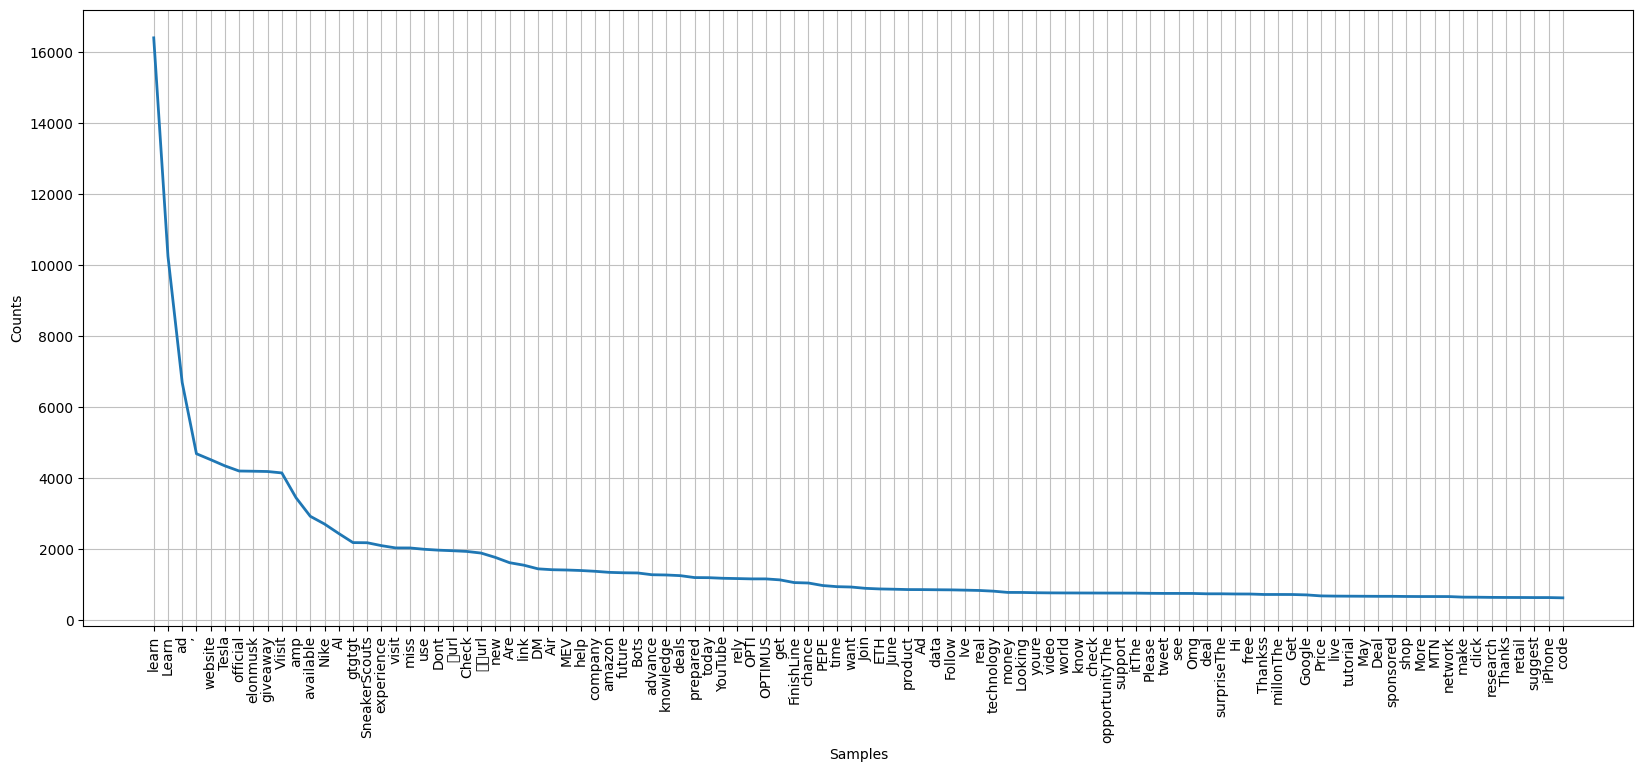

Most common collocations (bigrams)
[('AMDServer', 'intelhpc'), ('AirJordanRetro', 'Raging'), ('ArithmeticUSD', '📍Contract'), ('Blacksail', 'torchlightinfinite'), ('Blader', 'FoxeNews'), ('CaratGlobal', 'Archrival'), ('Ce', 'soir'), ('DD0587600', 'BlackRed'), ('Deutsche', 'Telekom'), ('Elijah', 'Watt'), ('Foxe', 'Blader'), ('Grounded', 'Pentiment'), ('HARVARD', 'ALUMNI'), ('Hyatt', 'Regency'), ('MIKE', 'TROUT'), ('MSIoT', 'IntelIoT'), ('Maruma', 'Mrema'), ('MobileInnovation', 'MSIoT'), ('Mrema', 'cochairperson'), ('NFTArt', 'NFTArtist'), ('NFTArtist', 'NFTCollector'), ('Raging', 'Bulls'), ('Starburst', 'Juicyverse'), ('Thiruvarur', 'வைகாசிமுகூர்த்தம்'), ('WMNS', 'AirJordan1'), ('Watt', 'Sells'), ('calamities', 'befall'), ('cochairperson', 'TNFD'), ('findyourpurpose', 'HirePurpose'), ('meded', 'eMednews'), ('renouncement', 'softcap'), ('revisions', 'OMBs'), ('torchlightXD', 'Gratuit'), ('torchlightinfinite', 'torchlight'), ('வைகாசி', 'முகூர்த்தம்'), ('𝘽𝙚𝙨𝙩', '𝙤𝙛'), ('𝙤𝙛', '𝙩𝙝𝙚'), ('𝙩𝙝𝙚',

In [ ]:
from time import time
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Retrieve all tweets from the database
query = "SELECT DISTINCT * FROM tweets"
df_tweets = pd.read_sql_query(query, conn)
#Tweet_id is column 0, text is column 3


t0 = time()
totalSentences = 0
totalEmoticons = 0
totalSlangs = 0
totalSlangsFound = []
totalElongated = 0
totalMultiExclamationMarks = 0
totalMultiQuestionMarks = 0
totalMultiStopMarks = 0
totalAllCaps = 0

# Iterate over each row in df_tweets
for index, row in df_tweets.iterrows():
    totalSentences += 1
    feat = []

    tweet_id = row['tweet_id']
    text     = removeUnicode(row['text'])  # Technique 0
    text     = replaceURL(row['text'])

    wordCountBefore = len(re.findall(r'\w+', text))  # word count of one sentence before preprocess

    emoticons = countEmoticons(text)  # how many emoticons in this sentence
    totalEmoticons += emoticons

    text = removeEmoticons(text)  # removes emoticons from text
    tokens = tokenize(text, wordCountBefore, tweet_id)

    # print("Processed tweet:", tweet_id)  # Print the tweet ID after processing

# View the resulting preprocessed data
print(preprocessed_data.head())

print("Total sentences: ",                          totalSentences,"\n")
print("Total Words before preprocess: ",            len(re.findall(r'\w+', ' '.join(df_tweets['text']))))
print("Total Distinct Tokens before preprocess: ",  len(set(re.findall(r'\w+', ' '.join(df_tweets['text'])))))
print("Average word/sentence before preprocess: ",  len(re.findall(r'\w+', ' '.join(df_tweets['text']))) / totalSentences, "\n")
print("Total Words after preprocess: ",             len(tokens))
print("Total Distinct Tokens after preprocess: ",   len(set(tokens)))
print("Average word/sentence after preprocess: ",   len(tokens)/totalSentences,"\n")


print("Total run time: ",                           time() - t0," seconds\n")

print("Total emoticons: ",                          totalEmoticons,"\n")
print("Total slangs: ",                             totalSlangs,"\n")
# commonSlangs = nltk.FreqDist(totalSlangsFound)
# for (word, count) in commonSlangs.most_common(20): # most common slangs across all texts
#     print(word,"\t",count)
# commonSlangs.plot(20, cumulative=False) # plot most common slangs

print("Total elongated words: ",                    totalElongated,"\n")
print("Total multi exclamation marks: ",            totalMultiExclamationMarks)
print("Total multi question marks: ",               totalMultiQuestionMarks)
print("Total multi stop marks: ",                   totalMultiStopMarks,"\n")
print("Total all capitalized words: ",              totalAllCaps,"\n")

#print(tokens)
commonWords = nltk.FreqDist(tokens)
print("Most common words ")
print("Word\tCount")
for (word, count) in commonWords.most_common(100): # most common words across all texts
    print(word,"\t",count)

# Create a larger plot with adjusted dimensions
plt.figure(figsize=(20, 8))  # Adjust the width and height as needed
commonWords.plot(100, cumulative=False) # plot most common words


bgm = nltk.collocations.BigramAssocMeasures()
tgm = nltk.collocations.TrigramAssocMeasures()
bgm_finder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
tgm_finder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
bgm_finder.apply_freq_filter(5) # bigrams that occur at least 5 times
print("Most common collocations (bigrams)")
print(bgm_finder.nbest(bgm.pmi, 50)) # top 50 bigram collocations
tgm_finder.apply_freq_filter(5) # trigrams that occur at least 5 times
print("Most common collocations (trigrams)")
print(tgm_finder.nbest(tgm.pmi, 20)) # top 20 trigrams collocations

In [ ]:
# Merge the preprocessed_data DataFrame with df_tweets based on tweet_id
df_tweets_preprocessed = df_tweets.merge(preprocessed_data, on='tweet_id', how='left', suffixes=('_original', '_preprocessed'))

# Deduplicate the merged DataFrame based on the 'tweet_id' column
df_tweets_preprocessed = df_tweets_preprocessed.drop_duplicates(subset=['tweet_id', 'text_preprocessed'])

**USER RANKING TEMPLATE**

### 6 Parts in BERT TOPIC MODELLING:
1. Embedding Model
 2. Dimensionality Reduction
 3. Clustering
 4. Vectorizer
 5. TF-IDF
 6. Fine Tune Topics

#### EMBEDDING MODEL
BERTopic starts with transforming our input documents into numerical representations. Although there are many ways this can be achieved, we typically use sentence-transformers ("all-MiniLM-L6-v2") as it is quite capable of capturing the semantic similarity between documents.

However, there is not one perfect embedding model and you might want to be using something entirely different for your use case.
This modularity allows us not only to choose any embedding model to convert our documents into numerical representations, we can use essentially any data to perform our clustering. When new state-of-the-art pre-trained embedding models are released, BERTopic will be able to use them. As a result, BERTopic grows with any new models being released.

#### UMAP & its Hyperparameters
UMAP is a technique used for dimensionality reduction. In BERTopic, it is used to reduce the dimensionality of document embedding into something easier to use with HDBSCAN to create good clusters.
Why this particular clustering model over others? this is because it automatically identifies the number of clusters as opposed to k-means for example which requires a trial and error test to figure out the right number. HDBSCAN does it based on a density based method.
1. **n_neighbors**: number of neighboring sample points used when making the manifold approximation. Increasing this value often results in larger clusters being created.
2. **n_components**:  refers to the dimensionality of the embeddings after reducing them. This is set as a default to 5 to reduce dimensionality as much as possible whilst trying to maximize the information kept in the resulting embeddings. Although lowering or increasing this value influences the quality of embeddings, its effect is largest on the performance of HDBSCAN. Increasing this value too much and HDBSCAN will have a hard time clustering the high-dimensional embeddings. If you want to increase this value, I would advise setting using a metric for HDBSCAN that works well in high dimensional data.
3. **metric**: refers to the method used to compute the distances in high dimensional space. The default is cosine as we are dealing with high dimensional data.


#### HDBSCAN & Its Hyperparameters
After reducing the embeddings with UMAP, we use HDBSCAN to cluster our documents into clusters of similar documents. Similar to UMAP, HDBSCAN has many parameters that could be tweaked to improve the cluster's quality.
1. **min_cluster_size**: arguably the most important parameter in HDBSCAN.  It controls the minimum size of a cluster and thereby the number of clusters that will be generated. It is set to 10 as a default. Increasing this value results in fewer clusters but of larger size whereas decreasing this value results in more micro clusters being generated. Typically, I would advise increasing this value rather than decreasing it.
2. **min_samples**: is automatically set to min_cluster_size and controls the number of outliers generated. Setting this value significantly lower than min_cluster_size might help you reduce the amount of noise you will get. Do note that outliers are to be expected and forcing the output to have no outliers may not properly represent the data.
3. **metric**:  like with HDBSCAN is used to calculate the distances. Here, we went with euclidean as, after reducing the dimensionality, we have low dimensional data and not much optimization is necessary. However, if you increase n_components in UMAP, then it would be advised to look into metrics that work with high dimensional data.

#### Vectorizers
In topic modeling, the quality of the topic representations is key for interpreting the topics, communicating results, and understanding patterns. It is of utmost importance to make sure that the topic representations fit with your use case.
In practice, there is not one correct way of creating topic representations. Some use cases might opt for higher n-grams, whereas others might focus more on single words without any stop words.
1. **ngram_range**: allows us to decide how many tokens each entity is in a topic representation. For example, we have words like game and team with a length of 1 in a topic but it would also make sense to have words like hockey league with a length of 2
2. **stop_words**: In some of the topics, we can see stop words appearing like he or the.
Stop words are something we typically want to prevent in our topic representations as they do not give additional information to the topic
3. **min_df**:  typically an integer representing how frequent a word must be before being added to our representation. You can imagine that if we have a million documents and a certain word only appears a single time across all of them, then it would be highly unlikely to be representative of a topic. Typically, the c-TF-IDF calculation removes that word from the topic representation but when you have millions of documents, that will also lead to a very large topic-term matrix.
4. **max_features**: A parameter similar to min_df is max_features which allows you to select the top n most frequent words to be used in the topic representation. Setting this, for example, to 10_000 creates a topic-term matrix with 10_000 terms. This helps you control the size of the topic-term matrix directly without having to fiddle around with the min_df parameter:
5. **tokenizer**: The default tokenizer in the CountVectorizer works well for western languages but fails to tokenize some non-western languages, like Chinese.

In [ ]:
# from sklearn.metrics import silhouette_score
# from bertopic import BERTopic
# from bertopic.vectorizers import ClassTfidfTransformer
# from sentence_transformers import SentenceTransformer
# from bertopic.representation import TextGeneration
# from bertopic.representation import KeyBERTInspired
# from bertopic.representation import MaximalMarginalRelevance
# from sklearn.feature_extraction.text import CountVectorizer
# from umap import UMAP
# from transformers import pipeline, AutoModel
# from bertopic.representation import OpenAI
# from hdbscan import HDBSCAN
# import numpy as np

# my_model = BERTopic.load("/content/drive/MyDrive/Colab_Notebooks/Data/twitter_bert_model")

# # Build the pipeline with the current parameter settings
# stopwords_list      = list(stopwords.words('english')) + ['http', 'https', 'amp', 'com', 'gtgtgt', 'please', 'send', 'dm']
# vectorizer_model    = CountVectorizer(min_df=5,
#                                       ngram_range=(1,2),
#                                       stop_words=stopwords_list)
# embedding_model     = AutoModel.from_pretrained('roberta-base')
# umap_model          = UMAP(n_neighbors= 15,
#                            n_components= 7,
#                            min_dist= 0.1,
#                            random_state= 42)
# hdbscan_model       = HDBSCAN(min_cluster_size= 100,
#                               min_samples= 40,
#                               gen_min_span_tree=True,
#                               prediction_data=True)
# ctfidf = ClassTfidfTransformer(reduce_frequent_words=True)

# representation_model = KeyBERTInspired()
# # aspect_model1 = PartOfSpeech("en_core_web_sm")
# # aspect_model2 = [KeyBERTInspired(top_n_words=30), MaximalMarginalRelevance(diversity=.5)]
# # Add all models together to be run in a single `fit`
# # representation_model = {
# #    "Main": main_representation,
# #    "Aspect1":  aspect_model1,
# #    "Aspect2":  aspect_model2
# # }

# model = BERTopic(
#     umap_model=umap_model,
#     hdbscan_model=hdbscan_model,
#     embedding_model=embedding_model,
#     vectorizer_model=vectorizer_model,
#     representation_model = representation_model,
#     ctfidf_model=ctfidf,
#     top_n_words=10,
#     min_topic_size=100,
#     language='english',
#     calculate_probabilities=True,
#     verbose=True,
#     nr_topics = 50
#     )

# # Fit the BERTopic model
# topics, probs = model.fit_transform(df_tweets_preprocessed['text_preprocessed'])

# # Calculate silhouette score
# silhouette_avg = silhouette_score(probs, hdbscan_model.labels_)

# print(silhouette_avg)

In [ ]:
# # Method 1 - safetensors
# model.save("/content/drive/MyDrive/Colab_Notebooks/My_Models/", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

# # Method 2 - pytorch
# model.save("/content/drive/MyDrive/Colab_Notebooks/My_Models/", serialization="pytorch", save_ctfidf=True, save_embedding_model=embedding_model)

# # Method 3 - pickle
# model.save("/content/drive/MyDrive/Colab_Notebooks/My_Models/twitter_bert_model", serialization="pickle")

In [ ]:
# Use the "c-TF-IDF" strategy with a threshold
# new_topics = model.reduce_outliers(df_tweets_preprocessed['text_preprocessed'], topics, strategy="c-tf-idf")
# model.update_topics(df_tweets_preprocessed['text_preprocessed'], topics=new_topics)

In [ ]:
# Assign the updated topics to the DataFrame
# df_tweets_preprocessed['updated_topics'] = new_topics

In [ ]:
# freq = model.get_topic_info()
# freq

In [ ]:
# import sys

# # Define a file path where you want to save the output
# output_file_path = 'output.txt'

# # Create a file for writing the output
# with open(output_file_path, 'w') as output_file:
#     # Redirect sys.stdout to the output file
#     sys.stdout = output_file

#     best_topics = [1, 5, 10, 17, 21]
#     for i in best_topics:
#         df_tweets_topic_i = df_tweets_preprocessed[df_tweets_preprocessed['updated_topics'] == i]
#         df_tweets_topic_i = pd.merge(
#             df_tweets_topic_i,
#             freq,
#             how="left",
#             left_on=['updated_topics'],
#             right_on=['Topic']
#         )
#         name = freq[freq['Topic'] == i]['Name']
#         print(f"Topic: {name}")
#         print(df_tweets_topic_i['text_original'].head(100))

# # Reset sys.stdout to its original value to print to the console again
# sys.stdout = sys.__stdout__

In [ ]:
# #Which topics are you interested in?

# # 1_twitch_sponsored_stream_game: STREAMING, GAMING - 2
# # 4_climate_energy_learn_unep	: ENVIRONMENT & ENERGY SUSTAINABILITY - 4
# # 9_health_research_cancer_dr: HEALTH AND CANCER RESEARCH & INNOVATION - 10
# # 17_ai_machinelearning_future_cc: ARTIFICIAL INTELLGIENCE RESEARCH & INNOVATION - 17
# # 22_women_un_amp_learn	: HUMAN RIGHTS, EQUALITY, AND WOMEN EMPOWERMENT - 22
# custom_name_list = {1: "Tesla Giveaway",
#                     2: "Streaming & Gaming",
#                     3: "Optimus",
#                     4: "Nike Ads",
#                     5: "Crypto" ,
#                     6: "Environment & Energy Sustainability",
#                     7: "Amazon Deals",
#                     8: "Youtube Education",
#                     9: "Spam",
#                     10: "Blockchain Spam",
#                     11: "Health and Cancer Research & Innovation",
#                     12: "Online Deals",
#                     13: "Ford Car Deals",
#                   # 14: "LinkedIn Events",
#                     15: "Iphone Network",
#                     16: "Memes",
#                     17: "Media",
#                     18: "Artificial Intelligence Research & Innovation",
#                     19: "News",
#                     20: "Ebay Sports Trading Cards",
#                     21: "Shopping",
#                     22: "Human Rights & Equality"}

The topic labels are currently automatically generated by taking the top 3 words and combining them using the _ separator. Although this is an informative label, in practice, this is definitely not the prettiest nor necessarily the most accurate label. For example, although the topic label 1_space_nasa_orbit is informative, but we would prefer to have a bit more intuitive label, such as space travel. The difficulty with creating such topic labels is that much of the interpretation is left to the user. Would space travel be more accurate or perhaps space explorations? To truly understand which labels are most suited, going into some of the documents in topics is especially helpful.

Although we can go through every single topic ourselves and try to label them, we can start by creating an overview of labels that have the length and number of words that we are looking for. To do so, we can generate our list of topic labels with .generate_topic_labels and define the number of words, the separator, word length, etc:



In [ ]:
# model.set_topic_labels(custom_name_list)

In [ ]:
# model.custom_labels_

In [ ]:
# freq = model.get_topic_info()
# freq

In [ ]:
model = BERTopic.load("/content/drive/MyDrive/Colab_Notebooks/My_Models")
freq = model.get_topic_info()
freq

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,0,4403,0_viisit_official_giveaway_tesla,Tesla Giveaway,"[viisit, official, giveaway, tesla, url, elonmusk, website, miss, dont, opportunitythe]",NaN
1,1,1709,1_twitch_sponsored_stream_game,Streaming & Gaming,"[twitch, sponsored, stream, game, live, ad, come, play, playstation, diablo]",NaN
2,2,1324,2_optimus_opti_rely_prepared,Optimus,"[optimus, opti, rely, prepared, advance, knowledge, company, are, use, experience]",NaN
3,3,2250,3_nike_sneakerscouts_gtgtgt_available,Nike Ads,"[nike, sneakerscouts, gtgtgt, available, air, finishline, ad, retail, jumpman23, womens]",NaN
4,4,1140,4_eth_ive_bots_mev,Crypto,"[eth, ive, bots, mev, sandwiching, tutorial, click, memecoins, pepe, youre]",NaN
5,5,1434,5_energy_climate_learn_unep,Environment & Energy Sustainability,"[energy, climate, learn, unep, sustainable, change, sustainability, amp, report, usaid]",NaN
6,6,1502,6_deal_amazon_deals_listige,Amazon Deals,"[deal, amazon, deals, listige, rtitbot, suggest, warehouse, price, money, tweet]",NaN
7,7,1206,7_channel_youtube_do_video,Youtube Education,"[channel, youtube, do, video, content, something, also, project, learn, submit]",NaN
8,8,1065,8_please_send_dm_wed,Spam,"[please, send, dm, wed, like, hi, details, sorry, message, hear]",NaN
9,9,1621,9_blockchain_future_crypto_web3,Blockchain Spam,"[blockchain, future, crypto, web3, defi, nft, healthcare, join, bnb, fx1]",NaN


In [ ]:
print((type(model.topics_)))

<class 'list'>


In [ ]:
print(type(model.custom_labels_))

<class 'list'>


In [ ]:
freq

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,0,4403,0_viisit_official_giveaway_tesla,Tesla Giveaway,"[viisit, official, giveaway, tesla, url, elonmusk, website, miss, dont, opportunitythe]",NaN
1,1,1709,1_twitch_sponsored_stream_game,Streaming & Gaming,"[twitch, sponsored, stream, game, live, ad, come, play, playstation, diablo]",NaN
2,2,1324,2_optimus_opti_rely_prepared,Optimus,"[optimus, opti, rely, prepared, advance, knowledge, company, are, use, experience]",NaN
3,3,2250,3_nike_sneakerscouts_gtgtgt_available,Nike Ads,"[nike, sneakerscouts, gtgtgt, available, air, finishline, ad, retail, jumpman23, womens]",NaN
4,4,1140,4_eth_ive_bots_mev,Crypto,"[eth, ive, bots, mev, sandwiching, tutorial, click, memecoins, pepe, youre]",NaN
5,5,1434,5_energy_climate_learn_unep,Environment & Energy Sustainability,"[energy, climate, learn, unep, sustainable, change, sustainability, amp, report, usaid]",NaN
6,6,1502,6_deal_amazon_deals_listige,Amazon Deals,"[deal, amazon, deals, listige, rtitbot, suggest, warehouse, price, money, tweet]",NaN
7,7,1206,7_channel_youtube_do_video,Youtube Education,"[channel, youtube, do, video, content, something, also, project, learn, submit]",NaN
8,8,1065,8_please_send_dm_wed,Spam,"[please, send, dm, wed, like, hi, details, sorry, message, hear]",NaN
9,9,1621,9_blockchain_future_crypto_web3,Blockchain Spam,"[blockchain, future, crypto, web3, defi, nft, healthcare, join, bnb, fx1]",NaN


In [ ]:
# print(pd.Series(model.topics_).value_counts())

In [ ]:
df_tweets_pp_temp = pd.concat([df_tweets_preprocessed, pd.Series(model.topics_)],
                 axis=1)

In [ ]:
print(df_tweets_pp_temp.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36370 entries, 0 to 36369
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tweet_id           36370 non-null  int64 
 1   author_id          36370 non-null  int64 
 2   created_at         36370 non-null  object
 3   text_original      36370 non-null  object
 4   tweet_metrics      36370 non-null  object
 5   entities           36370 non-null  object
 6   context            36370 non-null  object
 7   place_id           254 non-null    object
 8   text_preprocessed  36370 non-null  object
 9   0                  36370 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 3.1+ MB
None


In [ ]:
df_tweets_pp_final = df_tweets_pp_temp.merge(freq,
                                            how='left',
                                            left_on=0,
                                            right_on=['Topic'])

In [ ]:
best_topics = [1, 5, 10, 17, 21]
df_tweets_pp_final = df_tweets_pp_final[df_tweets_pp_final[0].isin(best_topics)]

In [ ]:
df_tweets_pp_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5618 entries, 6 to 36369
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tweet_id             5618 non-null   int64  
 1   author_id            5618 non-null   int64  
 2   created_at           5618 non-null   object 
 3   text_original        5618 non-null   object 
 4   tweet_metrics        5618 non-null   object 
 5   entities             5618 non-null   object 
 6   context              5618 non-null   object 
 7   place_id             45 non-null     object 
 8   text_preprocessed    5618 non-null   object 
 9   0                    5618 non-null   int64  
 10  Topic                5618 non-null   int64  
 11  Count                5618 non-null   int64  
 12  Name                 5618 non-null   object 
 13  CustomName           5618 non-null   object 
 14  Representation       5618 non-null   object 
 15  Representative_Docs  0 non-null      

In [ ]:
print(users_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14026 entries, 0 to 14025
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   author_id        14026 non-null  int64              
 1   username         14026 non-null  object             
 2   verified         14026 non-null  object             
 3   bio              14026 non-null  object             
 4   author_created   14026 non-null  datetime64[ns, UTC]
 5   author_location  14026 non-null  object             
 6   followers_count  14026 non-null  int64              
 7   following_count  14026 non-null  int64              
 8   tweet_count      14026 non-null  int64              
 9   entities         14026 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(4), object(5)
memory usage: 1.1+ MB
None


In [ ]:
users_df.head(10)

,author_id,username,verified,bio,author_created,author_location,followers_count,following_count,tweet_count,entities
0,10305,johnjwall,0,"@TrustInsights, photographer, husband, father, co-host of @MktgOverCoffee, and author of B2B Marketing Confessions.",2006-10-24 13:00:00+00:00,Boston,4684,2011,14105,"{""url"": {""urls"": [{""url"": ""http://t.co/qZiW3k2FMr"", ""expanded_url"": ""http://www.jw5150.com"", ""display_url"": ""jw5150.com"", ""indices"": [0, 22]}]}, ""description"": {""urls"": []}}"
1,11511,Acer,0,We create technology that empowers you to #MakeYourGreenMark,2006-11-05 01:46:51+00:00,,139345,414,34568,"{""url"": {""urls"": [{""url"": ""https://t.co/OKLUIWt4mH"", ""expanded_url"": ""https://linktr.ee/acerglobal"", ""display_url"": ""linktr.ee/acerglobal"", ""indices"": [0, 23]}]}, ""description"": {""urls"": []}}"
2,12522,cc_chapman,0,Professor. Creator. Digital Dad. Trying to leave it better than I found it.,2006-11-15 15:03:14+00:00,"Boston, MA",43466,24150,1911,"{""url"": {""urls"": [{""url"": ""https://t.co/k92JQnXlsC"", ""expanded_url"": ""https://www.cc-chapman.com"", ""display_url"": ""cc-chapman.com"", ""indices"": [0, 23]}]}, ""description"": {""urls"": []}}"
3,623623,Bwana,0,"Live, Laugh & Learn | 2 Timothy 1:7 🙏 Follower of Christ | Sponsored by @Corsair | #3dprinting | 📧business@bwana.tv",2007-01-10 22:57:00+00:00,"Jacksonville, FL",6351,138,19335,"{""url"": {""urls"": [{""url"": ""https://t.co/h2IlwZu9nw"", ""expanded_url"": ""http://solo.to/bwana"", ""display_url"": ""solo.to/bwana"", ""indices"": [0, 23]}]}, ""description"": {""urls"": []}}"
4,689273,CiscoUmbrella,0,Cisco Umbrella (formerly OpenDNS) provides the first line of defense against threats on the internet wherever users go. Support: umbrella-support@cisco.com,2007-01-23 22:10:38+00:00,San Francisco,76112,5543,11856,"{""url"": {""urls"": [{""url"": ""https://t.co/c2stIykSYB"", ""expanded_url"": ""https://umbrella.cisco.com"", ""display_url"": ""umbrella.cisco.com"", ""indices"": [0, 23]}]}, ""description"": {""urls"": []}}"
5,713973,ITPro,0,We provide the most comprehensive content to aid B2B IT decision making. Sign up to our NL https://t.co/Wb6iUyQhvV – & join us on LinkedIn https://t.co/LHjgdWbwr0,2007-01-27 13:38:00+00:00,"London, United Kingdom",25508,3899,58811,"{""url"": {""urls"": [{""url"": ""https://t.co/bQ1ySmB6TC"", ""expanded_url"": ""https://www.itpro.com"", ""display_url"": ""itpro.com"", ""indices"": [0, 23]}]}, ""description"": {""urls"": [{""url"": ""https://t.co/Wb6iUyQhvV"", ""expanded_url"": ""http://bit.ly/2r6I9ii"", ""display_url"": ""bit.ly/2r6I9ii"", ""indices"": [91, 114]}, {""url"": ""https://t.co/LHjgdWbwr0"", ""expanded_url"": ""http://bit.ly/2XVdymh"", ""display_url"": ""bit.ly/2XVdymh"", ""indices"": [139, 162]}]}}"
6,724253,xyz,0,.XYZ is the world’s favorite new domain ending. Follow to discover cutting-edge businesses & creators + website & branding tips.,2007-01-29 06:50:24+00:00,Santa Monica I Las Vegas,15047,1164,6653,"{""url"": {""urls"": [{""url"": ""https://t.co/8lngvgWOxe"", ""expanded_url"": ""https://gen.xyz"", ""display_url"": ""gen.xyz"", ""indices"": [0, 23]}]}, ""description"": {""urls"": []}}"
7,755991,BryanAlexander,0,"Education futurist. Author of Universities on Fire and Academia Next.\nWriter, speaker, convener, consultant, teacher.\n""The Ax-Wielding Futurist"" - Ozy",2007-02-07 13:52:20+00:00,"ÜT: 44.010713,-73.164997",15974,2488,80033,"{""url"": {""urls"": [{""url"": ""https://t.co/eHuFGzB3hs"", ""expanded_url"": ""http://futureofeducation.us"", ""display_url"": ""futureofeducation.us"", ""indices"": [0, 23]}]}, ""description"": {""urls"": []}}"
8,772368,Monster,0,Find the right fit. https://t.co/dYwBD0R9U5,2007-02-14 18:04:51+00:00,Worldwide,233692,5629,616146,"{""url"": {""urls"": [{""url"": ""https://t.co/lZ0YSrsxZV"", ""expanded_url"": ""http://Monster.com"", ""display_url"": ""Monster.com"", ""indices"": [0, 23]}]}, ""description"": {""urls"": [{""url"": ""https://t.co/dYwBD0R9U5"", 

In [ ]:
df_tweets_pp_final = df_tweets_pp_final.merge(users_df,
                                               on=['author_id'],
                                               how='left')

In [ ]:
print(df_tweets_pp_final.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5618 entries, 0 to 5617
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   tweet_id             5618 non-null   int64              
 1   author_id            5618 non-null   int64              
 2   created_at           5618 non-null   object             
 3   text_original        5618 non-null   object             
 4   tweet_metrics        5618 non-null   object             
 5   entities_x           5618 non-null   object             
 6   context              5618 non-null   object             
 7   place_id             45 non-null     object             
 8   text_preprocessed    5618 non-null   object             
 9   0                    5618 non-null   int64              
 10  Topic                5618 non-null   int64              
 11  Count                5618 non-null   int64              
 12  Name                

In [ ]:
df_tweets_pp_final.head(5)

,tweet_id,author_id,created_at,text_original,tweet_metrics,entities_x,context,place_id,text_preprocessed,0,Topic,Count,Name,CustomName,Representation,Representative_Docs,username,verified,bio,author_created,author_location,followers_count,following_count,tweet_count,entities_y
0,1658151809662308352,2396505878,2023-05-15 16:46:13,"Who else has been inspired to #RunAsYouAre by @GirlsWhoCode Founder @ReshmaSaujani? @VoteRunLead can train you to run for office + win! Join the community &amp; get plugged into #VRLHQ to learn more about running for office in an ever-changing world, &amp; engage with other #AAPI women! https://t.co/AJ0tmsWZcR","{""retweet_count"": 4, ""reply_count"": 1, ""like_count"": 6, ""quote_count"": 0, ""impression_count"": 1108}","{""annotations"": [{""start"": 31, ""end"": 41, ""probability"": 0.503, ""type"": ""Other"", ""normalized_text"": ""RunAsYouAre""}, {""start"": 179, ""end"": 183, ""probability"": 0.5818, ""type"": ""Other"", ""normalized_text"": ""VRLHQ""}, {""start"": 276, ""end"": 279, ""probability"": 0.5938, ""type"": ""Organization"", ""normalized_text"": ""AAPI""}], ""hashtags"": [{""start"": 30, ""end"": 42, ""tag"": ""RunAsYouAre""}, {""start"": 178, ""end"": 184, ""tag"": ""VRLHQ""}, {""start"": 275, ""end"": 280, ""tag"": ""AAPI""}], ""mentions"": [{""start"": 46, ""end"": 59, ""username"": ""GirlsWhoCode"", ""id"": ""430995737""}, {""start"": 68, ""end"": 82, ""username"": ""reshmasaujani"", ""id"": ""57172253""}, {""start"": 84, ""end"": 96, ""username"": ""VoteRunLead"", ""id"": ""2396505878""}], ""urls"": [{""start"": 288, ""end"": 311, ""url"": ""https://t.co/AJ0tmsWZcR"", ""expanded_url"": ""https://twitter.com/VoteRunLead/status/1658151809662308352/video/1"", ""display_url"": ""pic.twitter.com/AJ0tmsWZcR"", ""media_key"": ""7_1658151767421464620""}]}","[{""domain"": {""id"": ""10"", ""name"": ""Person"", ""description"": ""Named people in the world like Nelson Mandela""}, ""entity"": {""id"": ""1070735208247263235"", ""name"": ""Reshma Saujani"", ""description"": ""American politician""}}, {""domain"": {""id"": ""35"", ""name"": ""Politician"", ""description"": ""Politicians in the world, like Joe Biden""}, ""entity"": {""id"": ""1070735208247263235"", ""name"": ""Reshma Saujani"", ""description"": ""American politician""}}, {""domain"": {""id"": ""45"", ""name"": ""Brand Vertical"", ""description"": ""Top level entities that describe a Brands industry""}, ""entity"": {""id"": ""781974596157251587"", ""name"": ""Government/Education""}}, {""domain"": {""id"": ""30"", ""name"": ""Entities [Entity Service]"", ""description"": ""Entity Service top level domain, every item that is in Entity Service should be in this domain""}, ""entity"": {""id"": ""781974597226729473"", ""name"": ""Non-profit - Government/Education""}}, {""domain"": {""id"": ""46"", ""name"": ""Business Taxonomy"", ""description"": ""Categories within Brand Verticals that narrow down the scope of Brands""}, ""entity"": {""id"": ""1557697333571112960"", ""name"": ""Technology Business"", ""description"": ""Brands, companies, advertisers and every non-person handle with the profit intent related to softwares, apps, communication equipments, hardwares""}}, {""domain"": {""id"": ""47"", ""name"": ""Brand"", ""description"": ""Brands and Companies""}, ""entity"": {""id"": ""10043701943"", ""name"": ""Women in tech""}}, {""domain"": {""id"": ""30"", ""name"": ""Entities [Entity Service]"", ""description"": ""Entity Service top level domain, every item that is in Entity Service should be in this domain""}, ""entity"": {""id"": ""848920371311001600"", ""name"": ""Technology"", ""description"": ""Technology and computing""}}, {""domain"": {""id"": ""131"", ""name"": ""Unified Twitter Taxonomy"", ""description"": ""A taxonomy of user interests. ""}, ""entity"": {""id"": ""10043701943"", ""name"": ""Women in tech""}}, {""domain"": {""id"": ""131"", ""name"": ""Unified Twitter Taxonomy"", ""description"": ""A taxonomy of user inte

In [ ]:
# Assuming your DataFrame is named 'df'
df_tweets_pp_final.rename(columns={'0': 'topic'}, inplace=True)

In [ ]:
import ast
df_tweets_pp_final['tweet_metrics'] = df_tweets_pp_final['tweet_metrics'].apply(ast.literal_eval)

In [ ]:
df_tweets_pp_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5618 entries, 0 to 5617
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   tweet_id             5618 non-null   int64              
 1   author_id            5618 non-null   int64              
 2   created_at           5618 non-null   object             
 3   text_original        5618 non-null   object             
 4   tweet_metrics        5618 non-null   object             
 5   entities_x           5618 non-null   object             
 6   context              5618 non-null   object             
 7   place_id             45 non-null     object             
 8   text_preprocessed    5618 non-null   object             
 9   0                    5618 non-null   int64              
 10  Topic                5618 non-null   int64              
 11  Count                5618 non-null   int64              
 12  Name                

In [ ]:
df_tweets_pp_final['retweet_count']     = df_tweets_pp_final['tweet_metrics'].apply(lambda x: x.get('retweet_count', 0))
df_tweets_pp_final['reply_count']       = df_tweets_pp_final['tweet_metrics'].apply(lambda x: x.get('reply_count', 0))
df_tweets_pp_final['like_count']        = df_tweets_pp_final['tweet_metrics'].apply(lambda x: x.get('like_count', 0))
df_tweets_pp_final['impression_count']  = df_tweets_pp_final['tweet_metrics'].apply(lambda x: x.get('impression_count', 0))

In [ ]:
test.head(10)

In [ ]:
# Group by specified columns and aggregate metrics
df_tweets_grouped = df_tweets_pp_final.groupby(['author_id', 'username', 'followers_count', 'following_count', 'tweet_count', 'CustomName']).agg(
    total_tweets=('tweet_id', 'count'),
    total_retweets=('retweet_count', 'sum'),
    total_replies=('reply_count', 'sum'),
    total_likes=('like_count', 'sum'),
    total_impressions=('impression_count', 'sum')
).reset_index()

# Calculate average likes, impressions, and replies per tweet
df_tweets_grouped['avg_likes_per_tweet']        = df_tweets_grouped['total_likes'] / df_tweets_grouped['total_tweets']
df_tweets_grouped['avg_impressions_per_tweet']  = df_tweets_grouped['total_impressions'] / df_tweets_grouped['total_tweets']
df_tweets_grouped['avg_replies_per_tweet']      = df_tweets_grouped['total_replies'] / df_tweets_grouped['total_tweets']

In [ ]:
# Define weights for each criterion
weights = {
    'Followers': 0.2,
    'Tweets': 0.2,
    'Avg_Likes_Per_Tweet': 0.25,
    'Avg_Impressions_Per_Tweet': 0.25,
    'Avg_Replies_Per_Tweet': 0.10
}

# Calculate a weighted score for each user
df_tweets_grouped['user_score'] = (
    weights['Followers'] * df_tweets_grouped['followers_count'] +
    weights['Tweets'] * df_tweets_grouped['total_tweets'] +
    weights['Avg_Likes_Per_Tweet'] * df_tweets_grouped['avg_likes_per_tweet'] +
    weights['Avg_Impressions_Per_Tweet'] * df_tweets_grouped['avg_impressions_per_tweet'] +
    weights['Avg_Replies_Per_Tweet'] * df_tweets_grouped['avg_replies_per_tweet']
)

# Sort users by topic and user_score
sorted_grouped = df_tweets_grouped.sort_values(by=['CustomName', 'user_score'], ascending=[True, False])

# Get the top 5 users per topic
top_users_per_topic = sorted_grouped.groupby('CustomName').head(5)

In [ ]:
sorted_grouped[(sorted_grouped['total_tweets'] >= 3)]
# top_users_per_topic = sorted_grouped.groupby('CustomName')
# top_users_per_topic[top_users_per_topic['total_tweets'] > 25]

,author_id,username,followers_count,following_count,tweet_count,CustomName,total_tweets,total_retweets,total_replies,total_likes,total_impressions,avg_likes_per_tweet,avg_impressions_per_tweet,avg_replies_per_tweet,user_score
1716,555031989,Ronald_vanLoon,312073.0,173037.0,132893.0,Artificial Intelligence Research & Innovation,39,315,27,524,96366,13.435897,2470.923077,0.692308,6.304356e+04
158,16438898,NealSchaffer,228143.0,40557.0,245050.0,Artificial Intelligence Research & Innovation,4,2,1,6,1989,1.500000,497.250000,0.250000,4.575411e+04
918,92598387,NVIDIADC,41168.0,1751.0,9142.0,Artificial Intelligence Research & Innovation,4,11,3,43,5646,10.750000,1411.500000,0.750000,8.590038e+03
1038,128938832,PoetsAndQuants,28981.0,8071.0,42519.0,Artificial Intelligence Research & Innovation,3,0,3,6,1401,2.000000,467.000000,1.000000,5.914150e+03
366,21977192,Phocuswright,25932.0,2878.0,29658.0,Artificial Intelligence Research & Innovation,3,0,0,5,860,1.666667,286.666667,0.000000,5.259083e+03
2184,2396756364,MayoCancerCare,11822.0,1515.0,24362.0,Artificial Intelligence Research & Innovation,3,2,0,7,1279,2.333333,426.333333,0.000000,2.472167e+03
162,16523713,MassTLC,9461.0,1800.0,24832.0,Artificial Intelligence Research & Innovation,6,4,0,4,824,0.666667,137.333333,0.000000,1.927900e+03
2859,892630616927117312,NVIDIAAP,5643.0,15.0,3194.0,Artificial Intelligence Research & Innovation,3,2,0,7,439,2.333333,146.333333,0.000000,1.166367e+03
682,48000516,OEMOffHighway,4726.0,1255.0,8560.0,Artificial Intelligence Research & Innovation,5,0,0,9,545,1.800000,109.000000,0.000000,9.739000e+02
2580,4869937323,EEWorldOnline,4146.0,2278.0,10721.0,Artificial Intelligence Research & Innovation,3,1,0,0,250,0.000000,83.333333,0.000000,8.506333e+02


In [ ]:
top_users_per_topic = sorted_grouped.groupby('CustomName').head(5)

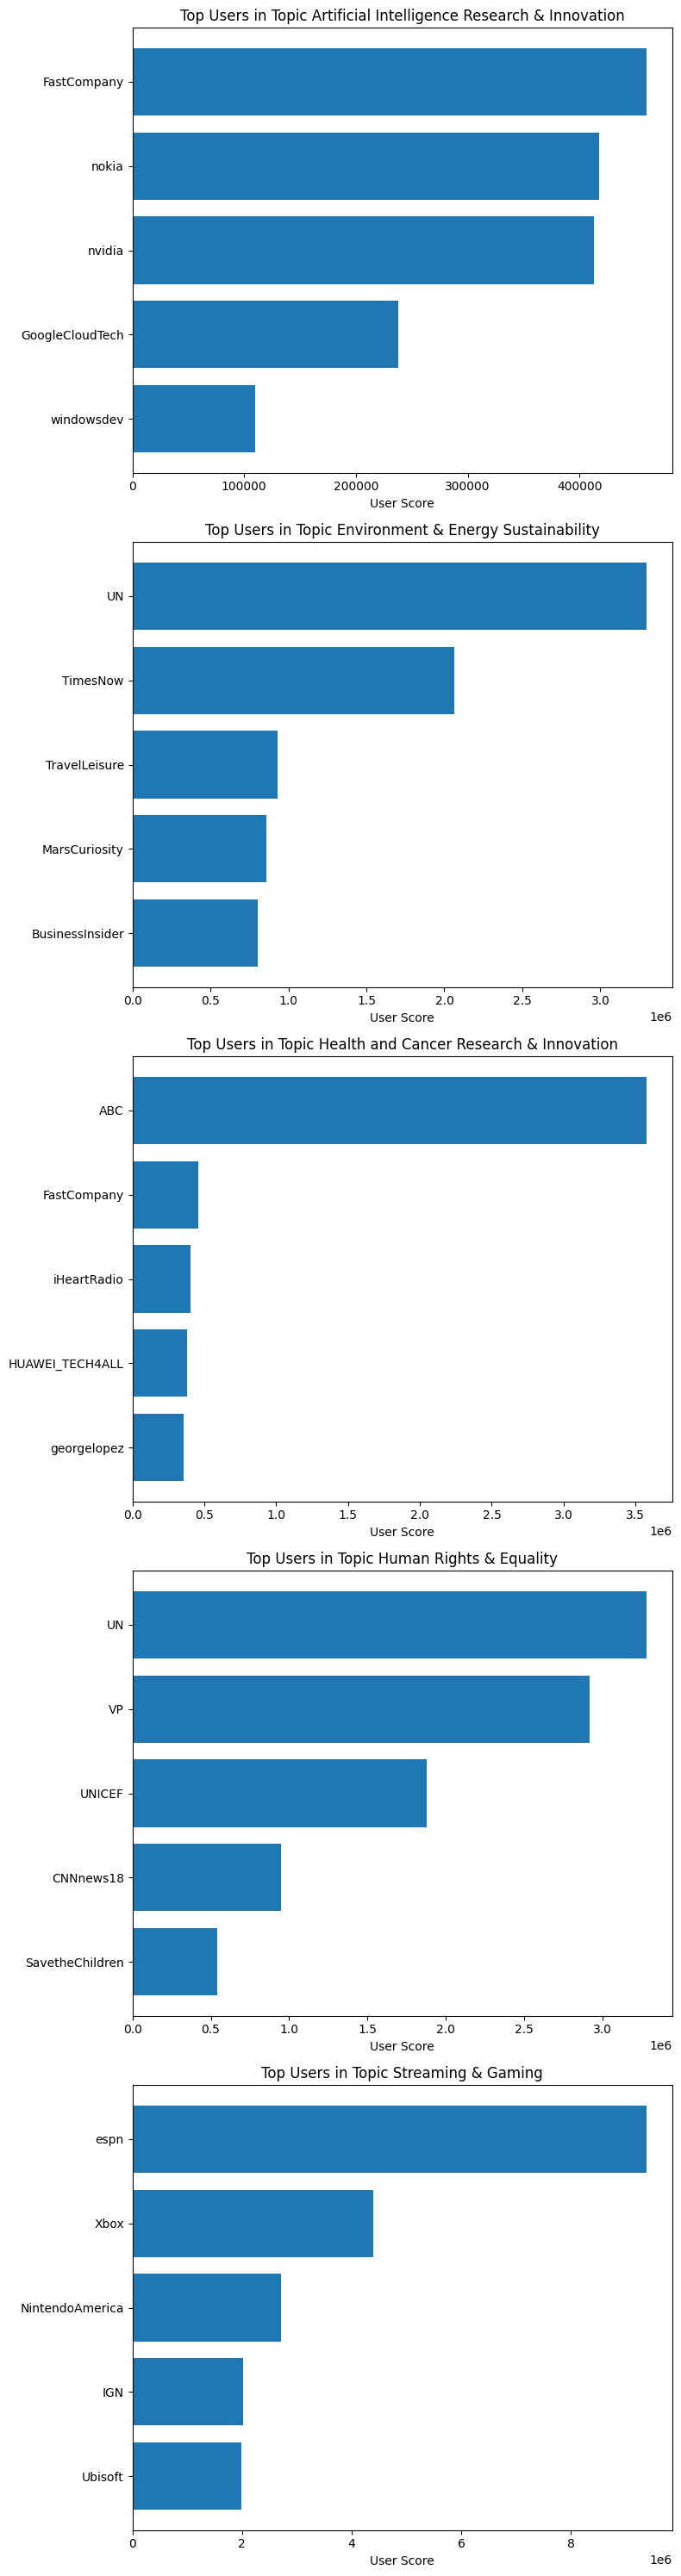

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already sorted the DataFrame and have 'top_users_per_topic'

# Create subplots for each topic
topics = top_users_per_topic['CustomName'].unique()
fig, axs = plt.subplots(len(topics), 1, figsize=(8, 6 * len(topics)))

for i, topic in enumerate(topics):
    users = top_users_per_topic[top_users_per_topic['CustomName'] == topic]
    x = users['username']
    y = users['user_score']

    axs[i].barh(x, y)
    axs[i].set_xlabel('User Score')
    axs[i].set_title(f'Top Users in Topic {topic}')
    axs[i].invert_yaxis()  # Invert y-axis to show the highest score at the top

plt.tight_layout()
plt.show()

In [ ]:
#Aggregate the data on topic and author id and username , following, followers, tweets total
# MEtrics: total tweets , total retweets, total likes, total impressions
# grouped = df_tweets_pp_final.groupby(['author_id',
#                                       'username',
#                                       'followers_count',
#                                       'following_count',
#                                       'tweet_count',
#                                       'topic',
#                                       'CustomName'])['tweet_id'].unique().reset_index()


In [ ]:
# import pandas as pd
# import numpy as np

# # Sample data (replace with your Twitter user data)
# data = {
#     'Username': ['User1', 'User2', 'User3'],
#     'Followers': [1000, 5000, 2000],
#     'Tweets': [200, 300, 150],
#     'Avg_Likes_Per_Tweet': [20, 15, 10],
#     'Avg_Comments_Per_Tweet': [5, 4, 3],
#     'Avg_Impressions_Per_Tweet': [5000, 6000, 4000],
# }

# # Create a DataFrame from the sample data
# df = pd.DataFrame(data)

# # Define weights for each criterion
# weights = {
#     'Followers': 0.2,
#     'Tweets': 0.1,
#     'Avg_Likes_Per_Tweet': 0.15,
#     'Avg_Comments_Per_Tweet': 0.15,
#     'Avg_Impressions_Per_Tweet': 0.15,
#     'Location': 0.05,
#     'Tweets_in_Domain': 0.1
# }

# # Normalize data (convert to values between 0 and 1)
# # You can use the min/max function to normalize the data -> normalization and standardization functions
# # Replicates what we do below but simpler way BTS.
# # in Sci-kit Learn you can use the normalize function in preprocessing module.
# for criterion in weights.keys():
#     df[criterion] = (df[criterion] - df[criterion].min()) / (df[criterion].max() - df[criterion].min())

# # Calculate scores for each user
# def calculate_score(row):
#     score = sum(row[criterion] * weight for criterion, weight in weights.items())
#     return score

# df['Score'] = df.apply(calculate_score, axis=1)

# # Rank users based on their scores
# df = df.sort_values(by='Score', ascending=False)

# # Display the ranked users
# print(df[['Username', 'Score']])


In [ ]:
best_topics = [1, 5, 10, 17, 21]
fig = model.visualize_barchart(topics = best_topics, custom_labels=False)
fig

You have to use a prompt for each topic after training in order to get the new topic. Let me know if you run into any issues while implementing it

In [ ]:
model.visualize_topics(topics=best_topics)

In [ ]:
model.visualize_hierarchy(topics=best_topics)

In [ ]:
#left join users data on to the final tweets data filtered for the best topics to get username, user metrics
df_tweets_preprocessed_with_users = df_tweets_preprocessed_final.merge(right=users_df,
                                                                 how='left',
                                                                 on='author_id')

In [ ]:
df_tweets_preprocessed_with_users.head(10)
#Pull all metrics into individual columns within the dictionary tweet_metrics
#

In [ ]:
group by author id, custom anem

In [ ]:
model.visualize_distribution(probs[200], min_probability=0.015)

## Rep Docs

- Represent the top tweets which are used to come up with the names
- You can use this when you manually validate the results as the name should indicate what all the tweets should represent
    - For example, the name indicates that 'ad' is one of the common words, however we do NOT want this within the name so we can remove that word in all tweets. remove any over-represented words in the cluster
- You can use TF-IDF to remove words that may be present in 80% of the documents for example. high frequency terms should be removed using that technique

In [ ]:
model.visualize_distribution(probs[200], min_probability=0.015)

In [ ]:
embeddings = embedding_model.encode(df_tweets_preprocessed['text_preprocessed'][:5000], show_progress_bar=False)
model.visualize_documents(df_tweets_preprocessed['text_preprocessed'][:5000], embeddings=embeddings)